In [1]:
import pandas as pd
import geopandas as gpd
import sqlalchemy
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import sklearn
import scipy
import logging
import missingno

# logger = logging.getLogger()
# logger.setLevel(logging.INFO)
# logging.Formatter('%(levelname)s: %(message)s')

In [2]:
# Connect to sqlite database
DB_PATH = Path('../../database/real_estate.sqlite')
engine = sqlalchemy.create_engine(f'sqlite:///{DB_PATH}')

In [3]:
# Get neighborhoods geometry
neighborhoods_gdf = gpd.read_file('../../database/neighborhoods.gpkg')

In [4]:
imgfolder = '/home/gus/Documents/github_repos/blog/static/images/masters_thesis/properties_table'

## Define functions

In [5]:
removes = {}
def log_removed_records(df:pd.DataFrame, prev_len:int, message:str):
    '''
    Logs the number of records removed after a certain step

    :param pd.DataFrame df: dataframe after processing
    :param int prev_len: number of rows before processing
    :param str message: message to log into the console
    :returns: new number of rows (after processing)
    :rtype: int
    '''
    new_len = len(df)
    logging.info(f'Removed {prev_len - new_len} {message}.')
    removes[message] = prev_len - new_len
    return new_len


# --- initial cleaning ------------------------------------------------------- #
# Fix data types
fix_types = {
    'construction': float,
    'bedrooms': int,
    'parking_spaces': int,
    'full_bathroom': int,
    'half_bathroom': int
    }

def clean_properties(df:pd.DataFrame, nieghborhoods_gdf:gpd.GeoDataFrame=neighborhoods_gdf) -> pd.DataFrame:
    '''
    Removes obvious errors and records with (essential) missing data from the
    dataframe. Specifically does the following:
    - Removes records without coordinates
    - Removes records without price and construction values
    - Removes duplicate properties (same link and different links)
    - Removes records with data that makes no sense or are obviously outliers
    - Fill missing values for non-essential columns
    - Removed properties outside of the neighborhoods limits (nieghborhoods_gdf)
    - Creates a new column: price_per_m²

    :param pd.DataFrame df: dataframe to clean
    :returns: filtered dataframe
    :rtype: pd.DataFrame
    '''
    prior = len(df)
    # remove records without coordinates
    df = df[(df['lat'].notna()) & (df['lon'].notna())]
    prior = log_removed_records(df, prior, 'without coordinates')

    df = df[df['bedrooms'].notna()]  # records without bedrooms information
    prior = log_removed_records( df, prior, 'without bedroom count information')

    # remove records without price or construction
    df = df[(df['price'].notna()) & (df['construction'].notna())]
    prior = log_removed_records(df, prior, 'without price or construction area')

    # remove duplicates
    df = df.drop_duplicates(subset='link', keep='first')  # same link
    df = df.drop_duplicates(subset=['lat', 'lon', 'price'], keep='first')  # posted multiple times (different links)
    prior = log_removed_records(df, prior, 'duplicated postings')

    # remove outliers
    for col in ['bedrooms', 'parking_spaces', 'half_bathroom', 'full_bathroom']:
        df = df[(df[col] <= 10) | df[col].isna()]
        prior = log_removed_records(df, prior, f'with ouliers in {col} column')

    # handle property_age column
    df['property_age'] = df['property_age'].replace('A estrenar', 0)  # new houses
    df = df[(df['property_age'] !=  'En construcción') & (df['property_age'].notna())]  #remove not finished houses
    
    prior = log_removed_records(df, prior, '"in construction" properties')
    
    df['property_age'] = df['property_age'].astype(int)
    df.loc[df['property_age'] >= 1000, 'property_age'] = 2025 - df['property_age']  # where they put the year instead of the age

    # missing values of non-essential variables
    df['parking_spaces'] = df['parking_spaces'].fillna(0)
    df['full_bathroom'] = df['full_bathroom'].fillna(1)  # assuming at least one full bathroom
    df['half_bathroom'] = df['half_bathroom'].fillna(0)

    # add geometry column
    geometry = gpd.points_from_xy(df['lon'], df['lat'])
    df = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    
    # remove properties outside of neighborhoods boundries
    df = gpd.sjoin(
        df,
        neighborhoods_gdf[['geometry', 'neighborhood']],
        how='inner',  # Only keep properties that intersect with neighborhoods
        predicate='within'  # Alternatively use 'intersects' if you want border properties
    ).drop(columns='index_right')  # drop index_right column
    
    prior = log_removed_records(df, prior, f'properties out of geographical bounds')

    # add price per m2 column
    df['price_per_m2'] = df['price'] / df['construction']

    # fix data types
    for key, val in fix_types.items():
        df[key] = df[key].astype(val)
        
    return df

In [6]:
# --- handle outliers -------------------------------------------------------- #
def domain_based_filtering(
        df:pd.DataFrame,
        price_bounds:list[int]=[1e5, 1e8],
        const_bounds:list[int]=[10, 5000],
        land_bounds:list[int]=[10, 5000]) -> pd.DataFrame:
    '''
    Remove physically impossible or commercially unrealistic values

    :param pd.DataFrame df: dataframe to process
    :param list[int] price_bounds: bounds for price column 
    :param list[int] const_bounds: bounds for construction column
    :param list[int] land_bounds: bounds for land column
    :returns: filtered df
    :rtype: pd.DataFrame
    '''
    for bounds in [price_bounds, const_bounds, land_bounds]:
        if len(bounds) != 2:
            raise Exception(f'Expected 2 values within bounds, got {len(bounds)}')

    prior = len(df)    
    df = df[(df['price'] >= price_bounds[0]) & (df['price'] <= price_bounds[1])]
    prior = log_removed_records(df, prior, f'price >= {price_bounds[0]:,} and <= {price_bounds[1]:,}')

    df = df[(df['construction'] >= const_bounds[0]) & (df['construction'] <= const_bounds[1])]
    prior = log_removed_records(df, prior, f'construction >= {const_bounds[0]:,} and <= {const_bounds[1]:,}')

    df = df[(df['land'] >= land_bounds[0]) & (df['land'] <= land_bounds[1])]
    prior = log_removed_records(df, prior, f'land >= {land_bounds[0]:,} and <= {land_bounds[1]:,}')
    
    return df

In [7]:
def iqr_filtering(df:pd.DataFrame, threshold:int=1.5, plot:bool=False) -> pd.DataFrame:
    '''
    Filters the price_per_m2 within the given threshold * IQR. Where
    IQR = Q3 - Q1.
    \nNOTE: a 1.5 threshold contains 99.3% of the data.

    :param pd.DataFrame df: dataframe to filter based on the price_per_m2 column
    :param int threshold: number of IQR to take as threshold
    :returns: filtered df
    :rtype:pd.DataFrame
    '''
    prior = len(df)
    q1, q3 = df['price_per_m2'].quantile([0.25, 0.75])
    iqr = q3 - q1

    # Plot
    if plot:
        plt.figure(figsize=(8,8))
        sns.set_style("darkgrid")
        ax = sns.boxplot(df['price_per_m2'], color="#416ab6")
        # ax.axhline(y=q1 - threshold*iqr, color='#c1121f', linestyle='--', label='Lower Threshold')
        # ax.axhline(y=q3 + threshold*iqr, color='#c1121f', linestyle='--', label='Upper Threshold')
        plt.title('Price per m² - Boxplot')
        plt.ylabel('Price per m²')
        plt.show()

    df = df[
        (df['price_per_m2'] >= q1 - threshold*iqr) & 
        (df['price_per_m2'] <= q3 + threshold*iqr)
    ]
    log_removed_records(df, prior, f'outliers out of {threshold} * IQR')

    return df

In [9]:
def modified_zscore_clean(
        df:pd.DataFrame,
        columns:list[str]=['price', 'construction', 'land'],
        threshold:float=3.5,
        plot:bool=False) -> pd.DataFrame:
    '''
    Removes outliers using the Modified Z-Score Method. Formula given by:
    Mod Z = 0.6745 (x - median) / MAD\n
    Where MAD is the Median Absolute Value.
    \nAlso, since the data is right-skewed, a log(1 + x) transformation is
    performed to normalize the distribution.

    :param pd.DataFrame df: dataframe to filter (remove outliers)
    :param list[str] columns: columns to analyze
    :returns: filtered dataframe
    :rtype: pd.DataFrame
    '''
    prior = len(df)
    if plot:
        fig, axes = plt.subplots(3, 1, figsize=(8, 12))
        i = 0

    for col in columns:
        log_data = np.log1p(df[col])  # log(1 + x) transformation
        median = np.median(log_data)  # median of log-transformed data
        mad = np.median(np.abs(log_data - median))  # Median Absolute Deviation
        df[f'{col}_mod_z'] = 0.6745 * (log_data - median) / mad  # modified z-score calculation
        
        if plot:
            ax = sns.histplot(df[f'{col}_mod_z'], ax=axes[i], kde=True, color='#416ab6')
            ax.set_xlabel('Modified Z-Score')
            ax.set_title(f'Log(1 + x) of {col.title()} - Modified Z-Score with thresholds')
            ax.axvline(x=threshold, linestyle=':', label='threshold', color='#c1121f')
            ax.axvline(x=-threshold, linestyle=':', label='threshold', color='#c1121f')
            i += 1
        
        # remove records with m z-score larger than threshold
        df = df[df[f'{col}_mod_z'].abs() <= threshold].copy()
    
    prior = log_removed_records(df, prior, f'outlier with z-score')
    plt.tight_layout() if plot else None  # adhust plot layout
        
    return df.drop(columns=[f'{col}_mod_z' for col in columns])

## Start data processing

In [ ]:
# Load raw data from sqlite
df_raw = pd.read_sql('SELECT * FROM properties_raw', con=engine)
removes['initial'] = len(df_raw)
print(f'\nRaw: {len(df_raw):>12,}')  # len before processing

# Basic processing
df = clean_properties(df=df_raw)
print(f'Processed: {len(df):>6,}')  # len after processing

print('-'*30,'\n',df['county'].value_counts())  # summary by county


Raw:        5,031
Processed:  3,349
------------------------------ 
 county
Zapopan        1732
Guadalajara    1617
Name: count, dtype: int64


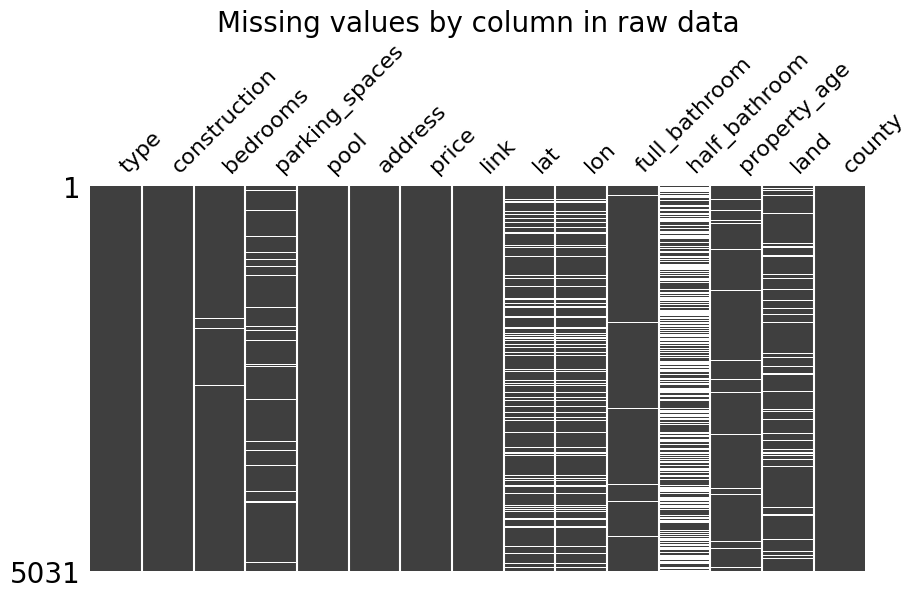

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
missingno.matrix(df_raw, ax=ax, sparkline=False)
plt.title('Missing values by column in raw data', fontsize=20)
plt.show()


domain based:       2,975


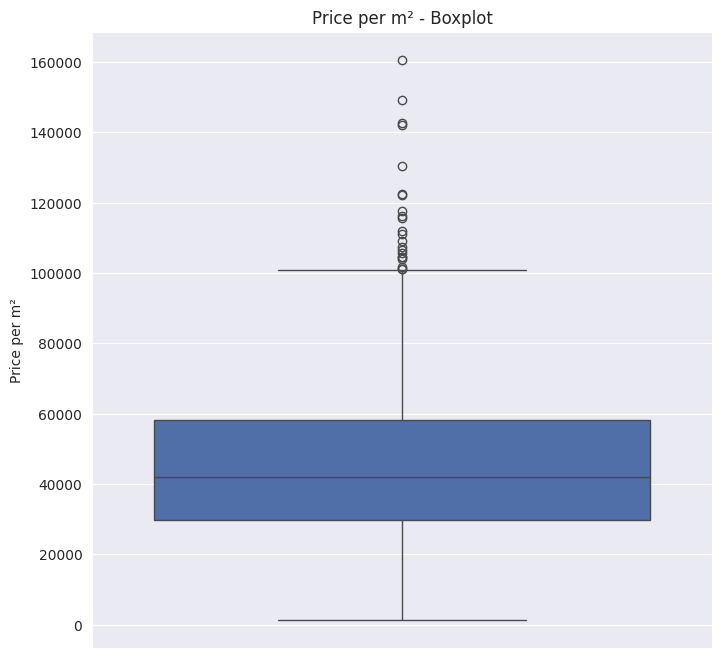

IQR filtering:      2,953
Z-Score filtering:  2,927


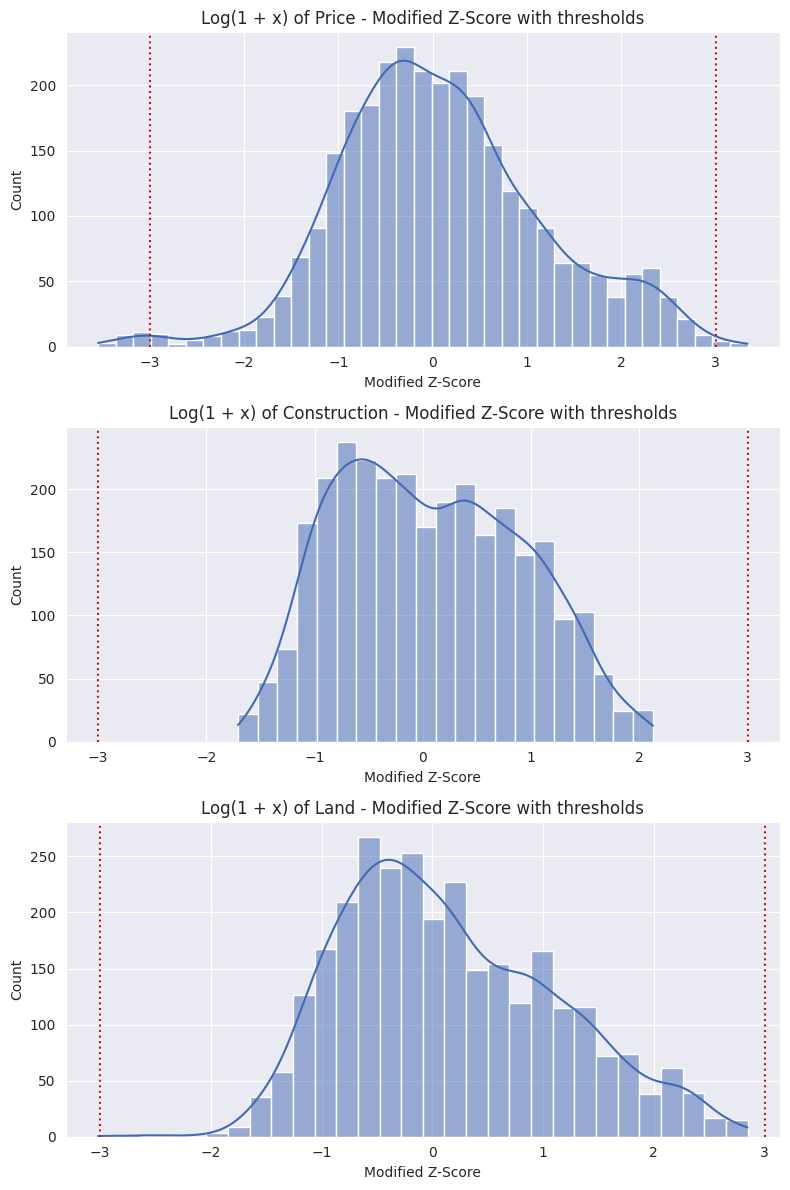

In [15]:
# Handling outliers (3 different methods)
filtered_df = domain_based_filtering(df.copy(), const_bounds=[10, 1200], land_bounds=[10, 1500])
print(f'\ndomain based: {len(filtered_df):11,}')

filtered_df = iqr_filtering(df=filtered_df, threshold=1.5, plot=True)
print(f'IQR filtering: {len(filtered_df):10,}')

filtered_df = modified_zscore_clean(df=filtered_df, threshold=3, plot=True)
print(f'Z-Score filtering: {len(filtered_df):6,}')

In [16]:
print('Summary\n')
processing_summary = pd.DataFrame({'Criteria':removes.keys(), 'Removed Records':removes.values()})
# Set the first 'Count' to 0 so the initial row shows the full total
initial_value = processing_summary.loc[0, 'Removed Records']
processing_summary.loc[0, 'Removed Records'] = 0
# Compute Remaining from 5031
processing_summary['Remaining'] = initial_value - processing_summary['Removed Records'].cumsum()
# Set the first row manually to show the initial total, in case it's useful
processing_summary.loc[0, 'Removed Records'] = initial_value

print(processing_summary.to_markdown(index=False))

Summary

| Criteria                                |   Removed Records |   Remaining |
|:----------------------------------------|------------------:|------------:|
| initial                                 |              5031 |        5031 |
| without coordinates                     |              1011 |        4020 |
| without bedroom count information       |                92 |        3928 |
| without price or construction area      |                 0 |        3928 |
| duplicated postings                     |               160 |        3768 |
| with ouliers in bedrooms column         |                19 |        3749 |
| with ouliers in parking_spaces column   |                13 |        3736 |
| with ouliers in half_bathroom column    |                 1 |        3735 |
| with ouliers in full_bathroom column    |                 0 |        3735 |
| "in construction" properties            |               199 |        3536 |
| properties out of geographical bounds   |            

In [15]:
# # Before-after comparison
# fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# # Price
# sns.histplot(np.log1p(df['price']), ax=axes[0,0], kde=True)
# axes[0,0].set_title('Original Price (log)')
# sns.histplot(np.log1p(filtered_df['price']), ax=axes[0,1], kde=True)
# axes[0,1].set_title('Cleaned Price (log)')

# #sns.histplot((df['price']), ax=axes[0,0], kde=True)
# #axes[0,0].set_title('Original Price (log)')
# #sns.histplot((filtered_df['price']), ax=axes[0,1], kde=True)
# #axes[0,1].set_title('Cleaned Price (log)')

# # Construction
# sns.histplot(df['construction'], ax=axes[1,0], kde=True)
# axes[1,0].set_title('Original Construction')
# sns.histplot(filtered_df['construction'], ax=axes[1,1], kde=True)
# axes[1,1].set_title('Cleaned Construction')

# # Price per m²
# sns.histplot(df['price_per_m2'], ax=axes[2,0], kde=True)
# axes[2,0].set_title('Original Price/m²')
# sns.histplot(filtered_df['price_per_m2'], ax=axes[2,1], kde=True)
# axes[2,1].set_title('Cleaned Price/m²')

# plt.tight_layout()

## Data transformation

In [18]:
# Create gated_community variable
filtered_df['gated_community'] = filtered_df['type'].map({'Casa en condominio':1}).fillna(0).astype(int)

# Modify and translate type variable
filtered_df['type'] = filtered_df['type'].map({
    'Casa': 'House',
    'Casa en condominio': 'House',
    'Departamento': 'Appartment'
}).astype('category')

# Get dummies for type column
to_export = pd.get_dummies(filtered_df, columns=['type'], prefix='type', dtype=int)
to_export = to_export.drop_duplicates(subset=['geometry', 'price'], keep='first', ignore_index=True)
to_export.to_file('../../database/properties.gpkg', driver="GPKG", index=False)  # export

/tmp/ipykernel_8752/4293134175.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  colors = filtered_df['type'].replace(color_map)


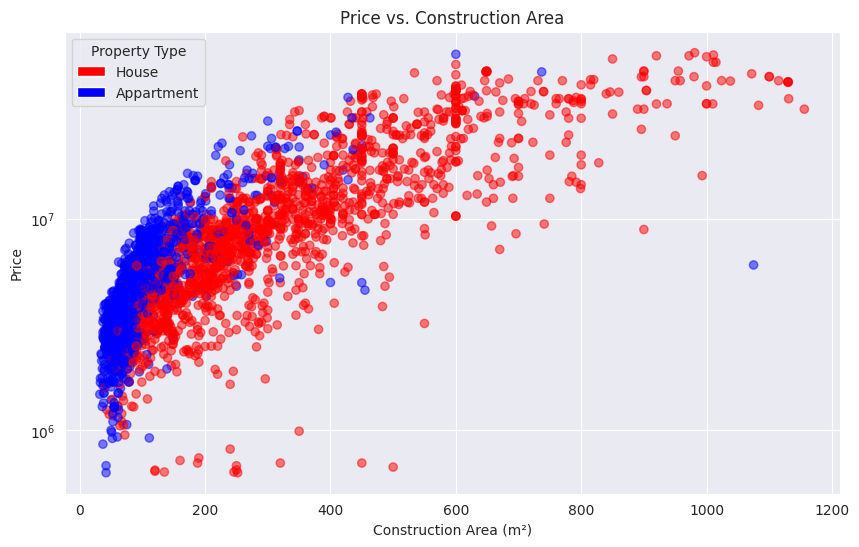

In [30]:
# Define color mapping
color_map = {'House': 'r', 'Appartment': 'b'}
colors = filtered_df['type'].replace(color_map)

plt.figure(figsize=(10,6))
plt.scatter(filtered_df['construction'], filtered_df['price'], c=colors, alpha=0.5)
plt.title('Price vs. Construction Area')
plt.xlabel('Construction Area (m²)')
plt.ylabel('Price')
plt.yscale('log')  # Log scale for better visualization

# Create legend handles manually
legend_elements = [Patch(facecolor=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_elements, title='Property Type')

plt.savefig(f'{imgfolder}/price_vs_area.png')
# Show the plot
plt.show()

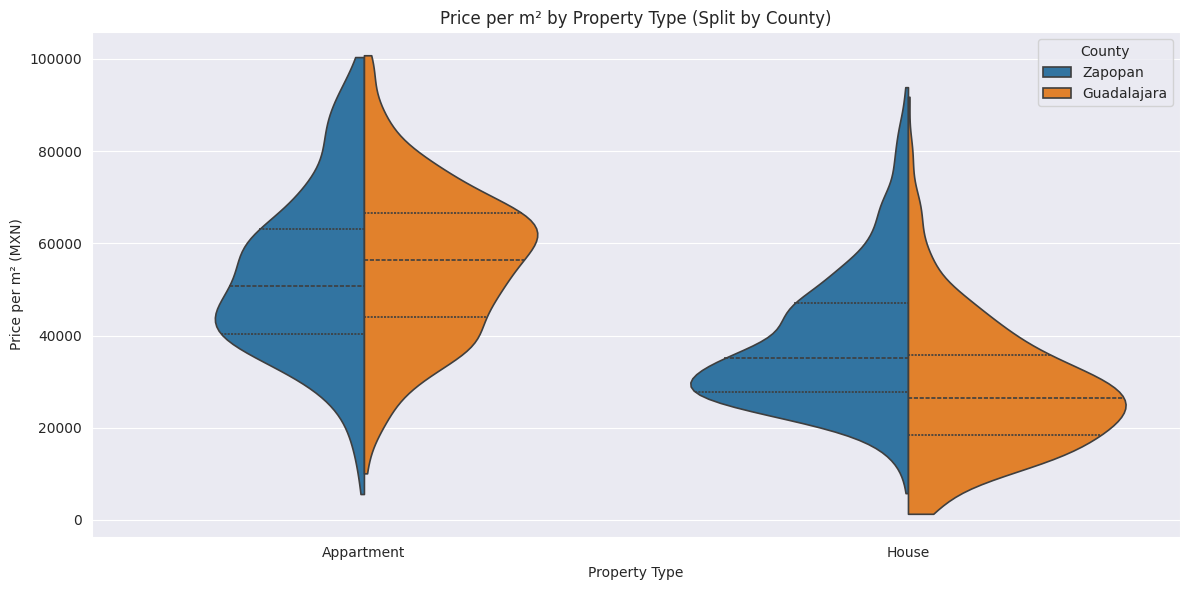

In [75]:
plt.figure(figsize=(12, 6))

sns.violinplot(
    data=filtered_df,
    x='type',             # Apartments vs Houses on X-axis
    y='price_per_m2',
    hue='county',         # Split by county
    split=True,           # Halves each violin by county
    palette={'Guadalajara': '#ff7f0e', 'Zapopan': '#1f77b4'},
    inner='quartile',
    linewidth=1.2,
    cut=0
)

plt.title('Price per m² by Property Type (Split by County)')
plt.ylabel('Price per m² (MXN)')
plt.xlabel('Property Type')
plt.legend(title='County')
plt.tight_layout()

plt.savefig(f'{imgfolder}/price_per_county_type.png')
plt.show()


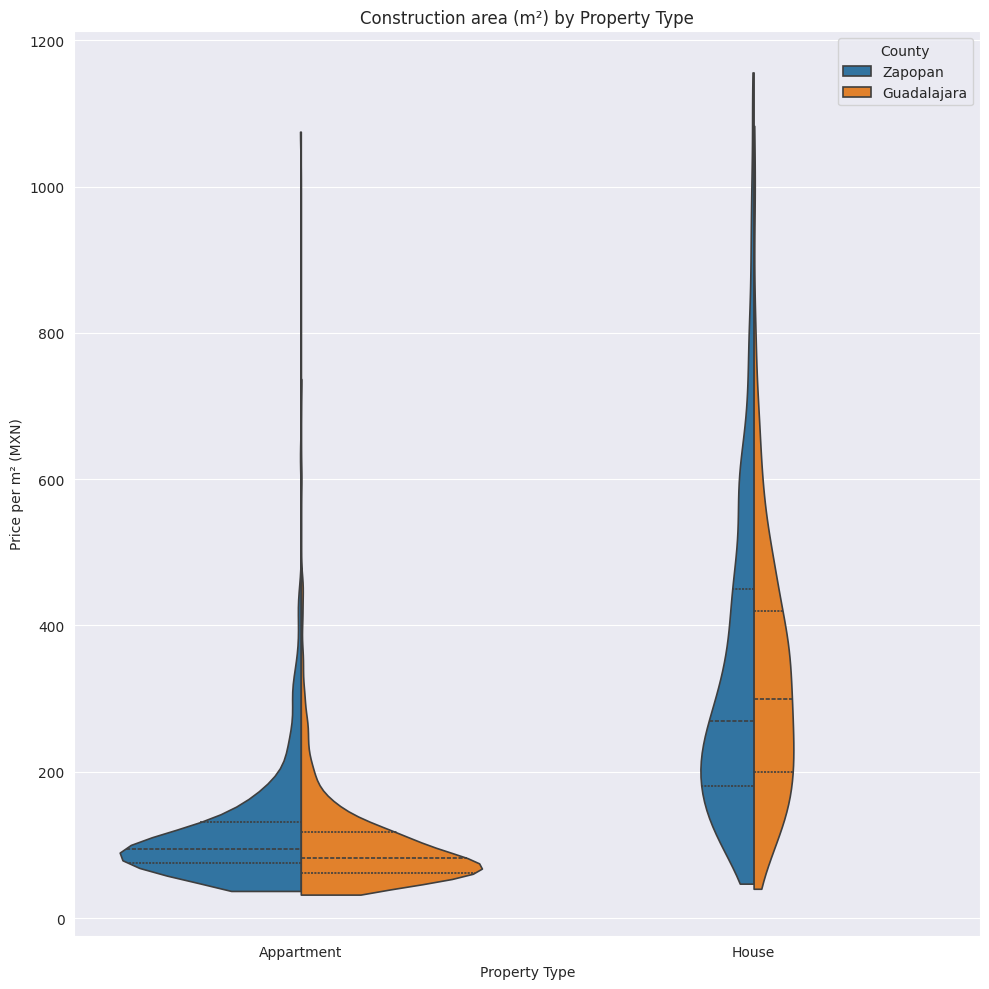

In [80]:
plt.figure(figsize=(10, 10))

sns.violinplot(
    data=filtered_df,#[filtered_df['type']=='Appartment'],
    x='type',             # Apartments vs Houses on X-axis
    y='construction',
    hue='county',         # Split by county
    split=True,           # Halves each violin by county
    palette={'Guadalajara': '#ff7f0e', 'Zapopan': '#1f77b4'},
    inner='quartile',
    linewidth=1.2,
    cut=0
)

plt.title('Construction area (m²) by Property Type')
plt.ylabel('Price per m² (MXN)')
plt.xlabel('Property Type')
plt.legend(title='County')
plt.tight_layout()

plt.savefig(f'{imgfolder}/construction_split_violin.png')
plt.show()


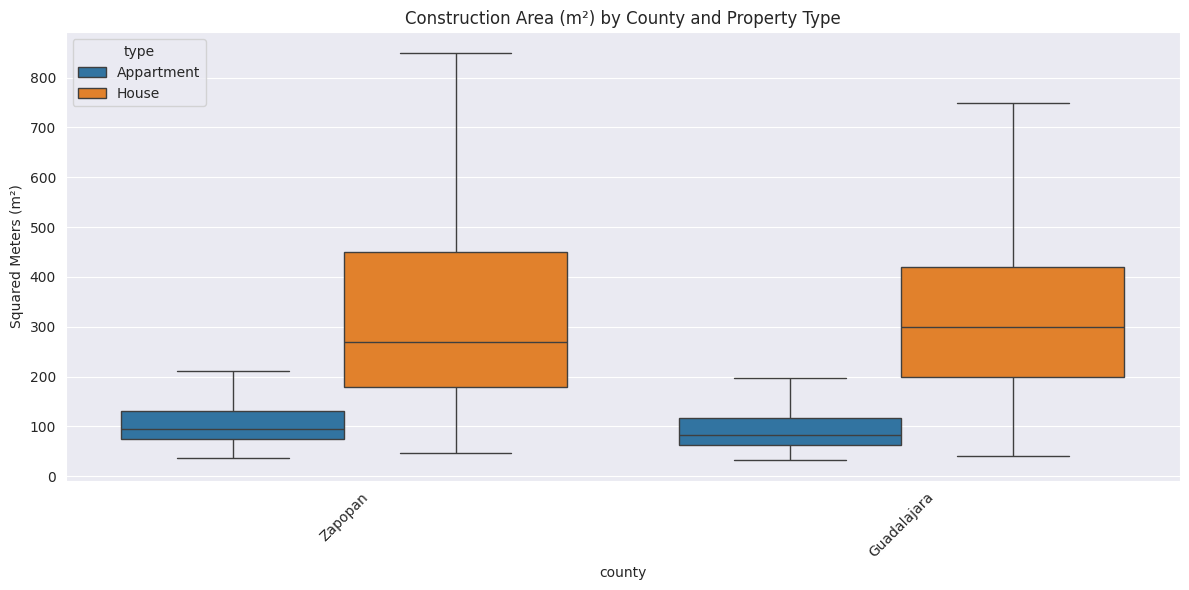

In [73]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df, x='county', y='construction', hue='type', showfliers=False)
plt.title('Construction Area (m²) by County and Property Type')
plt.ylabel('Squared Meters (m²)')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig(f'{imgfolder}/price_per_county_type.png')
plt.show()

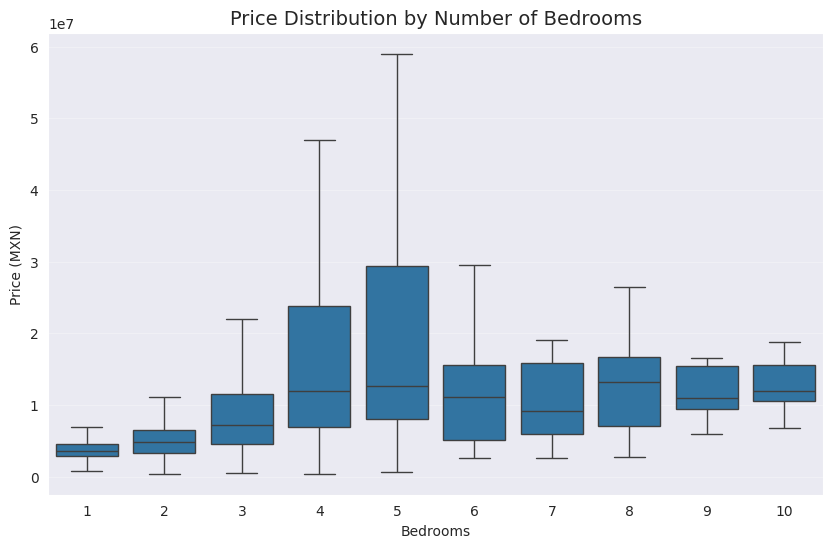

In [125]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='bedrooms',
    y='price',
    showfliers=False  # Hide outliers for cleaner plot
)
plt.title('Price Distribution by Number of Bedrooms', fontsize=14)
plt.xlabel('Bedrooms')
plt.ylabel('Price (MXN)')
#plt.yscale('log')  # Use if price range is wide
plt.grid(axis='y', alpha=0.3)
plt.savefig(f'{imgfolder}/price_vs_bedrooms.png')
plt.show()

In [81]:
filtered_df['bedrooms'].value_counts()

bedrooms
3     892
2     776
4     608
1     335
5     205
6      53
7      32
8      14
10      6
9       6
Name: count, dtype: int64

/tmp/ipykernel_8752/3597615451.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


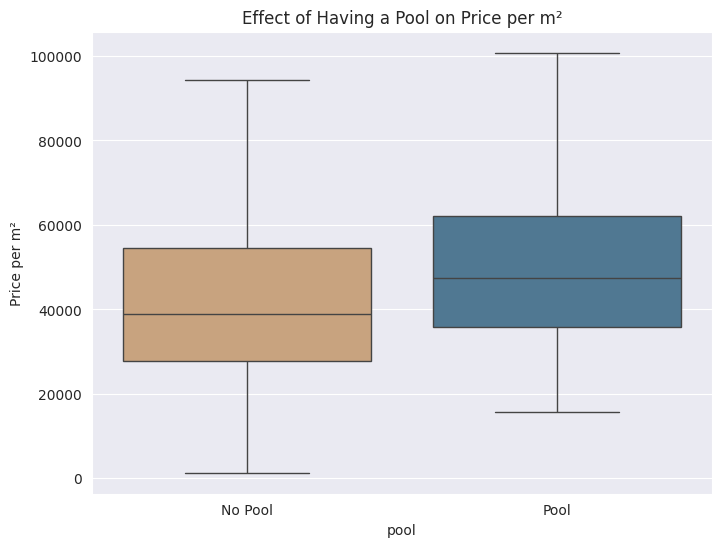

In [126]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=filtered_df,
    x='pool',
    y='price_per_m2',
    palette={'1':'#457b9d', '0':'#d4a373'},
    showfliers=False)
plt.title('Effect of Having a Pool on Price per m²')
plt.xticks([0, 1], ['No Pool', 'Pool'])
plt.ylabel('Price per m²')
plt.savefig(f'{imgfolder}/price_pool.png')
plt.show()

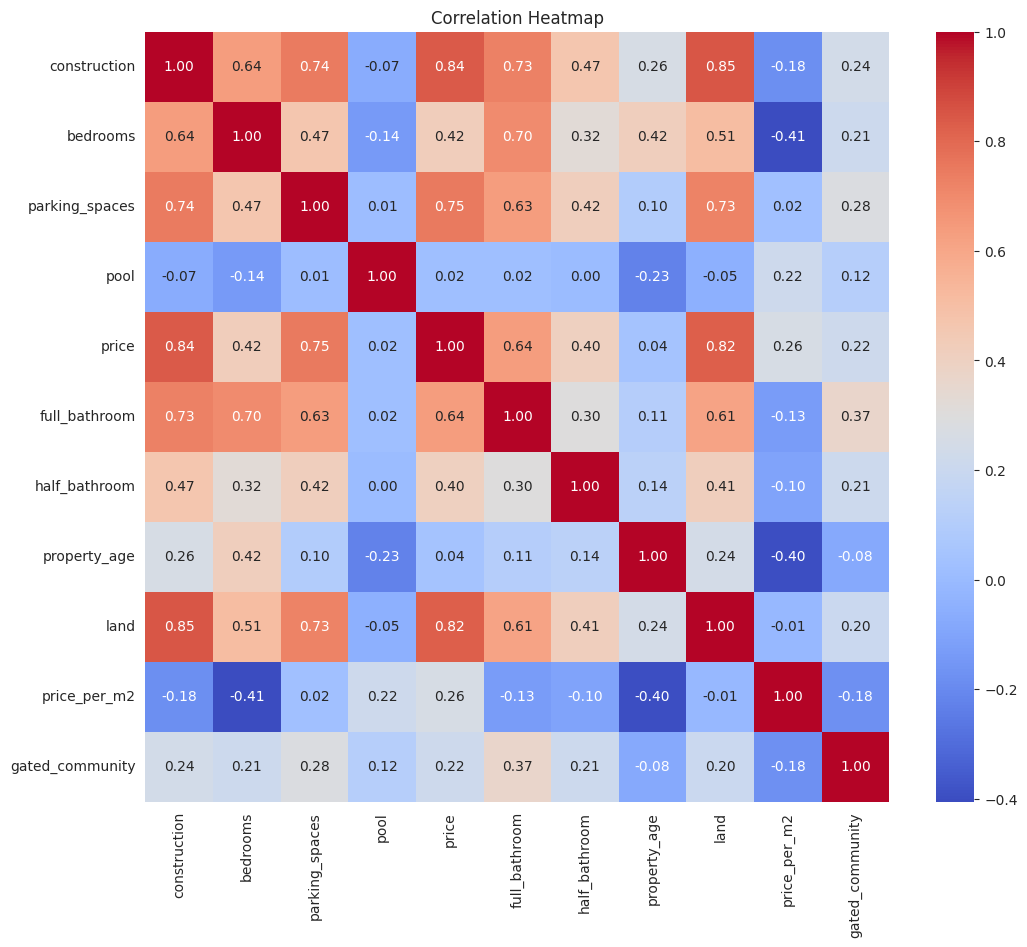

In [65]:
plt.figure(figsize=(12, 10))
numerical_cols = ['construction', 'bedrooms', 'parking_spaces', 'pool', 'price', 
                  'full_bathroom', 'half_bathroom', 'property_age', 'land', 'price_per_m2', 'gated_community']
corr = filtered_df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.savefig(f'{imgfolder}/numeric_vars_correlation.png')
plt.show()

In [71]:
corr = filtered_df[numerical_cols].corr().round(2)
corr.to_clipboard()

/tmp/ipykernel_8752/3840045702.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top, x='neighborhood', y='price_per_m2', palette=palette_dict, showfliers=False)


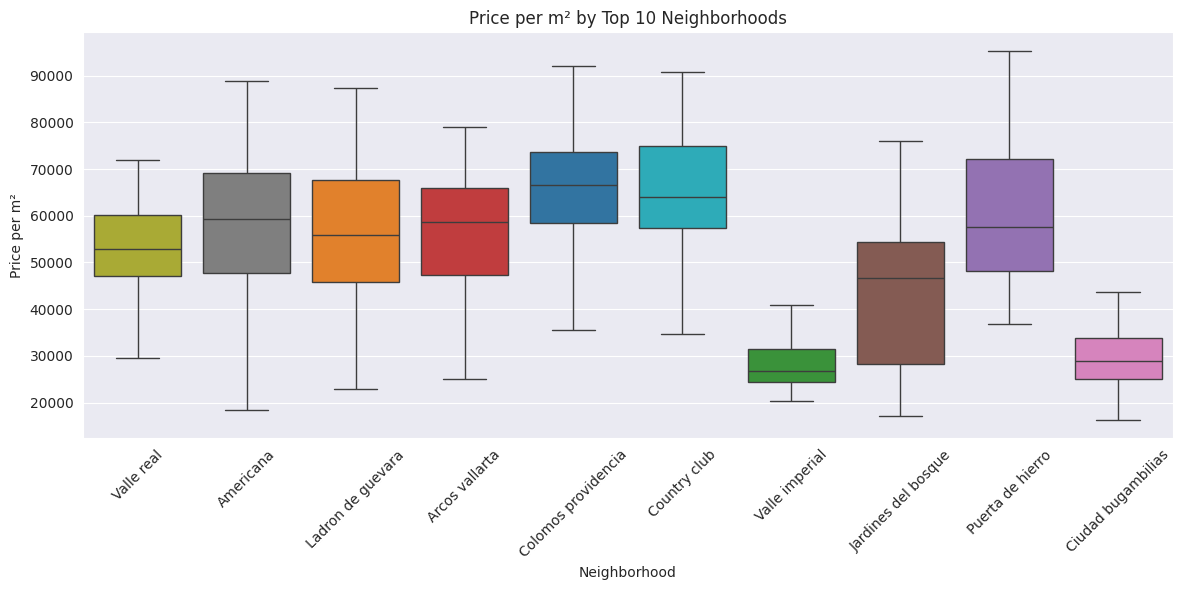

In [127]:
# Get top 10 neighborhoods
top_neigh = filtered_df['neighborhood'].value_counts().head(10).index

# Filter the DataFrame
df_top = filtered_df[filtered_df['neighborhood'].isin(top_neigh)]

# Create a color palette with as many colors as neighborhoods
neigh_colors = sns.color_palette('tab10', n_colors=len(top_neigh))  # or 'Set2', 'husl', etc.

# Map neighborhood names to colors
palette_dict = dict(zip(top_neigh, neigh_colors))

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top, x='neighborhood', y='price_per_m2', palette=palette_dict, showfliers=False)
plt.title('Price per m² by Top 10 Neighborhoods')
plt.xticks(rotation=45)
plt.ylabel('Price per m²')
plt.xlabel('Neighborhood')
plt.tight_layout()
plt.savefig(f'{imgfolder}/price_dist_top10_ngbds.png')
plt.show()


In [ ]:
# Get top 10 neighborhoods
top_neigh = filtered_df['neighborhood'].value_counts().head(10).index

# Filter the DataFrame
df_top = filtered_df[filtered_df['neighborhood'].isin(top_neigh)]

# Create a color palette with as many colors as neighborhoods
neigh_colors = sns.color_palette('Set2', n_colors=len(top_neigh))  # or 'Set2', 'husl', etc.

# Map neighborhood names to colors
palette_dict = dict(zip(top_neigh, neigh_colors))

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top, x='neighborhood', y='price_per_m2', palette=palette_dict, showfliers=False)
plt.title('Price per m² by Top 10 Neighborhoods')
plt.xticks(rotation=45)
plt.ylabel('Price per m²')
plt.xlabel('Neighborhood')
plt.tight_layout()
plt.savefig(f'{imgfolder}/price_dist_top10_ngbds.png')
plt.show()


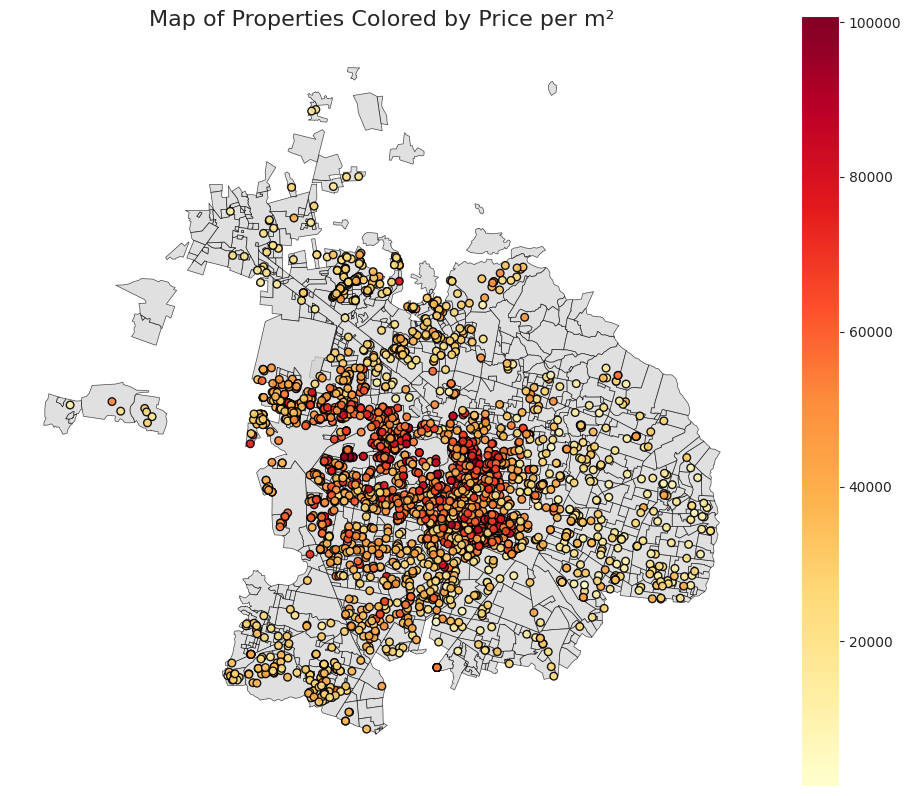

In [28]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

norm = Normalize(vmin=filtered_df['price_per_m2'].min(), vmax=filtered_df['price_per_m2'].max())

# Set figure size
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the properties, coloring by price_per_m2
neighborhoods_gdf.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7,
)
filtered_df.plot(
    ax=ax,
    column='price_per_m2',
    cmap='YlOrRd',  # Other good options: 'plasma', 'inferno', 'coolwarm'
    legend=True,
    markersize=30,
    alpha=0.9,
    edgecolor='k'
)

# Add title and axis off
ax.set_title('Map of Properties Colored by Price per m²', fontsize=16)
ax.set_axis_off()

plt.savefig(f'{imgfolder}/price_by_property.png')
plt.show()

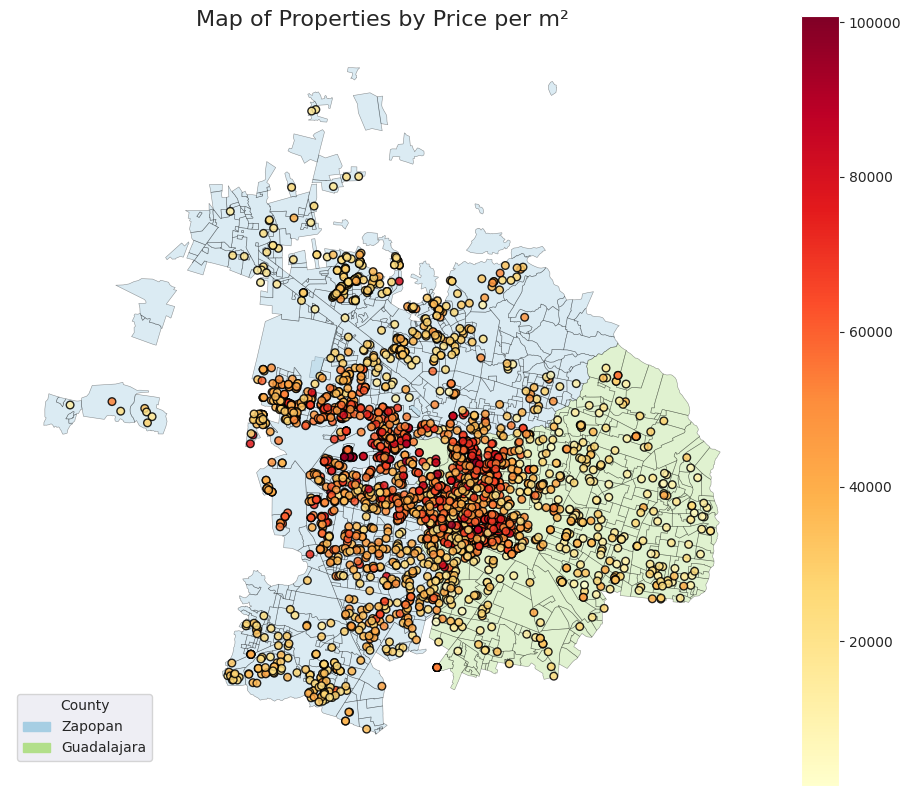

In [36]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 10))

# Define colors manually for each county
county_colors = {
    'Zapopan': '#a6cee3',     # light blue
    'Guadalajara': '#b2df8a'  # light green
}

# Plot neighborhoods with manual colors
neighborhoods_gdf.plot(
    ax=ax,
    color=neighborhoods_gdf['county'].map(county_colors),  # map county → color
    edgecolor='black',
    linewidth=0.4,
    alpha=0.4
)

# Plot properties by price_per_m2
filtered_df.plot(
    ax=ax,
    column='price_per_m2',
    cmap='YlOrRd',
    markersize=30,
    alpha=0.85,
    edgecolor='black',
    legend=True
)

# --- Add custom legend for counties ---
county_patches = [
    mpatches.Patch(color=color, label=county)
    for county, color in county_colors.items()
]
ax.legend(
    handles=county_patches,
    title='County',
    loc='lower left'  # adjust position (could also be 'upper right', etc.)
)

ax.set_title('Map of Properties by Price per m²', fontsize=16)
ax.set_axis_off()

plt.show()


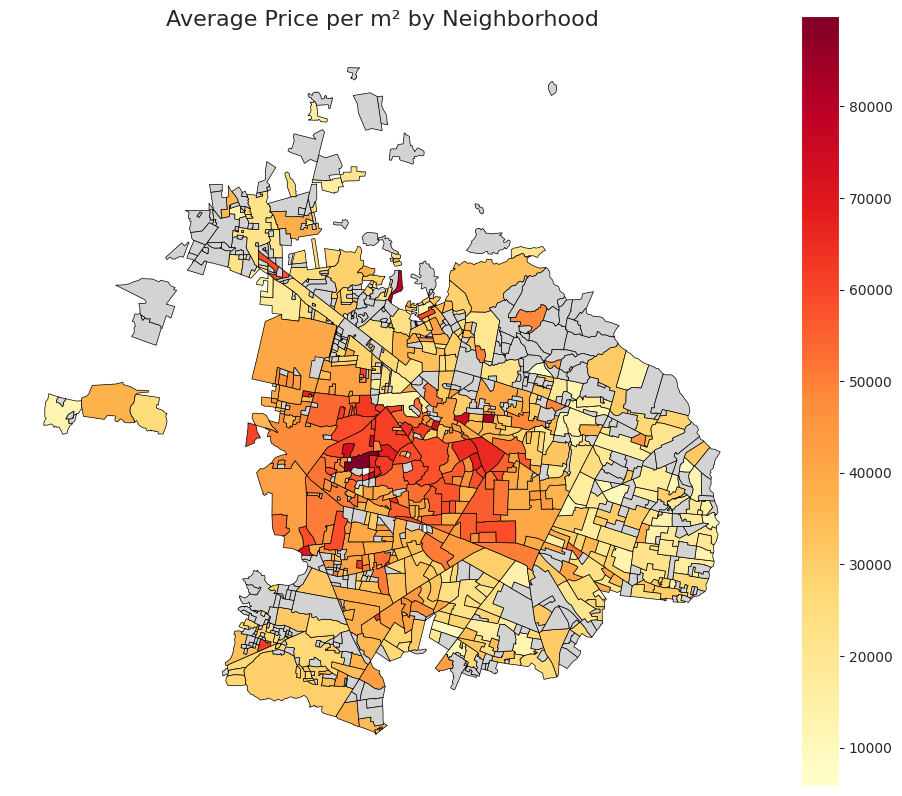

In [68]:
# Step 1: Aggregate average price_per_m2 per neighborhood
avg_price_by_neigh = filtered_df.groupby('neighborhood')['price_per_m2'].mean().reset_index()

# Step 2: Merge with neighborhood polygons
neighborhoods_plot = neighborhoods_gdf.merge(avg_price_by_neigh, on='neighborhood', how='left')

# Step 3: Plot
fig, ax = plt.subplots(figsize=(12, 10))
neighborhoods_plot.plot(
    ax=ax,
    column='price_per_m2',
    cmap='YlOrRd',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
ax.set_title('Average Price per m² by Neighborhood', fontsize=16)
ax.set_axis_off()
plt.savefig(f'{imgfolder}/price_by_neighborhood.png')
plt.show()

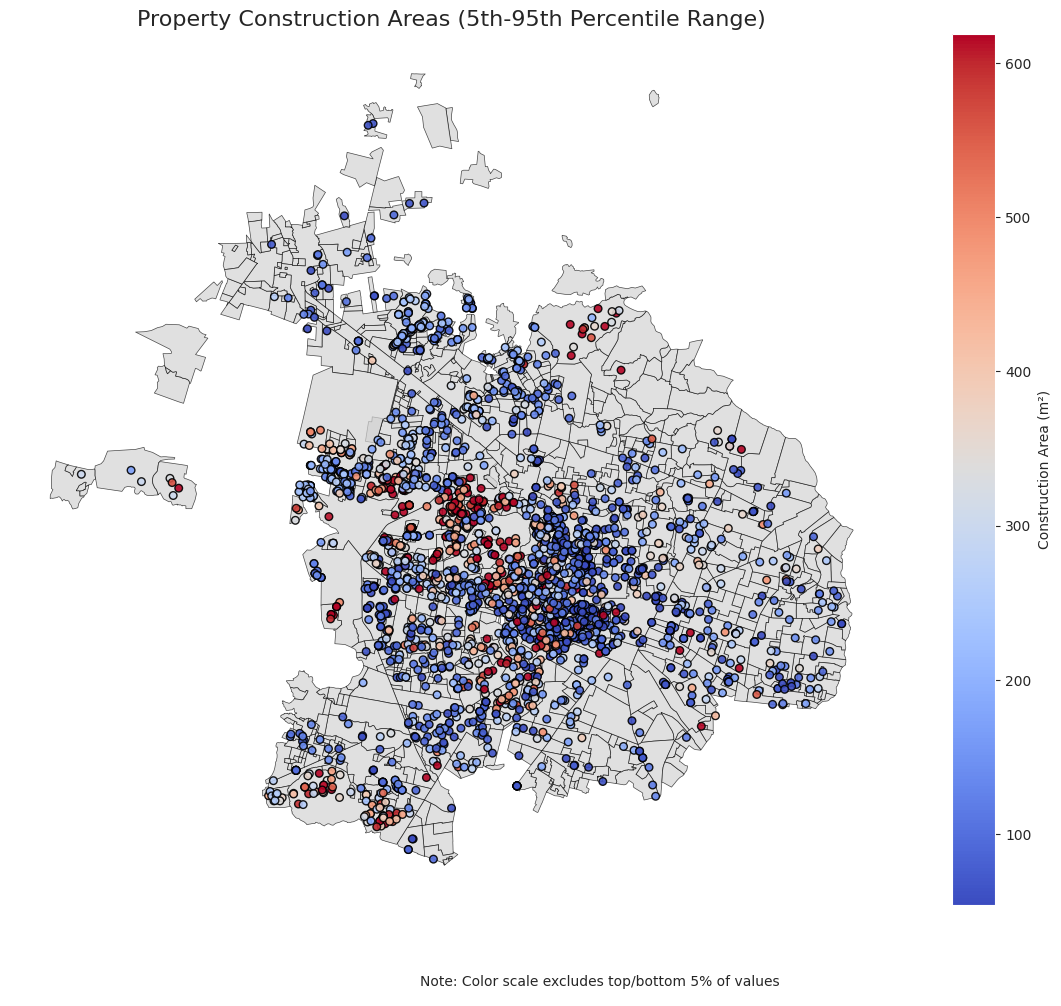

In [101]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

# Calculate percentiles to exclude extreme outliers
lower_bound = np.percentile(filtered_df['construction'], 5)  # 5th percentile
upper_bound = np.percentile(filtered_df['construction'], 95)  # 95th percentile

# Create normalized color scale using percentiles
norm = Normalize(vmin=lower_bound, vmax=upper_bound)

# Set figure size
fig, ax = plt.subplots(figsize=(12, 10))

# Plot base map (neighborhood boundaries)
neighborhoods_gdf.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7,
)

# Plot properties with robust color scaling
scatter = filtered_df.plot(
    ax=ax,
    column='construction',
    cmap='coolwarm',
    norm=norm,  # Apply our robust normalization
    legend=True,
    markersize=30,
    alpha=0.9,
    edgecolor='k',
    legend_kwds={'label': "Construction Area (m²)"}
)

# Add informative title
ax.set_title('Property Construction Areas (5th-95th Percentile Range)', fontsize=16)
ax.set_axis_off()

# Add annotation about clipped outliers
ax.annotate('Note: Color scale excludes top/bottom 5% of values',
            xy=(0.5, 0.02), xycoords='figure fraction',
            ha='center', fontsize=10)

plt.tight_layout()
plt.show()

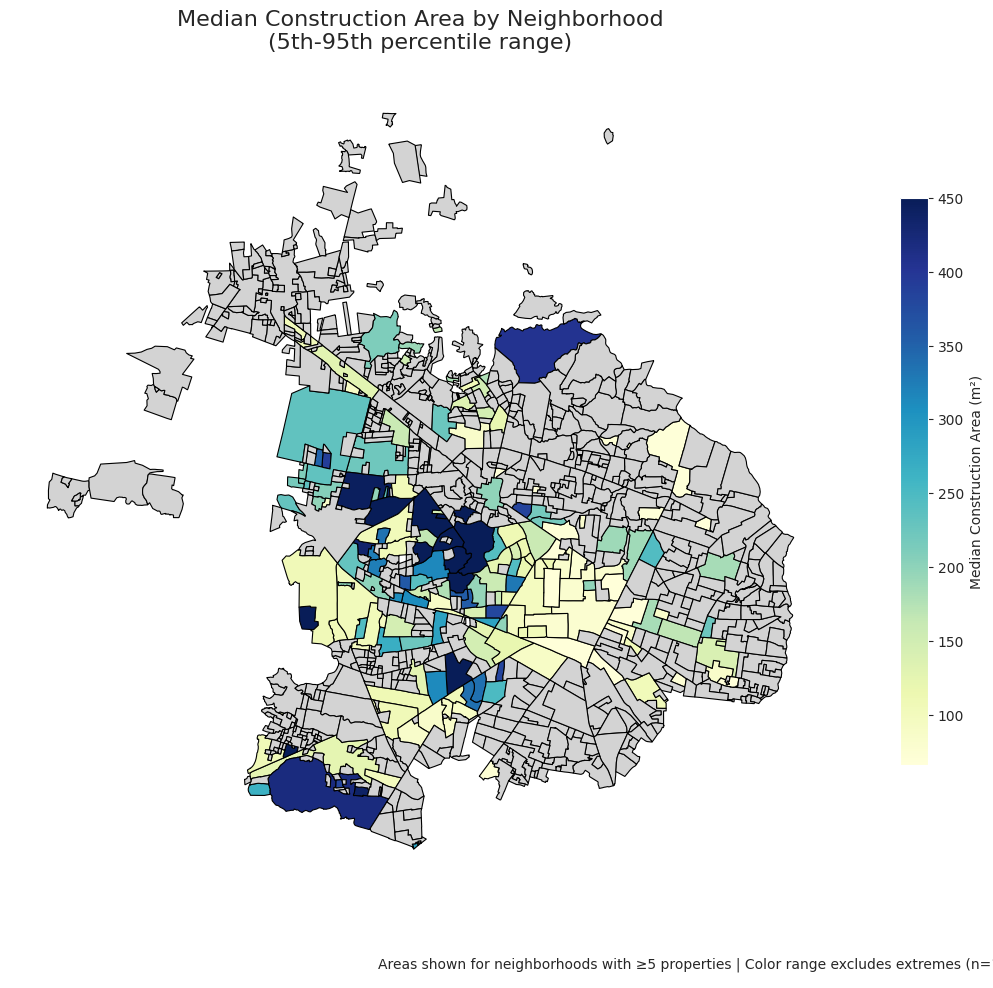

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Step 1: Aggregate construction area data by neighborhood with robust statistics
neigh_stats = filtered_df.groupby('neighborhood')['construction'].agg(
    ['median', 'count', 'mean', 'std']
).reset_index()

# Filter neighborhoods with sufficient data points (e.g., at least 5 properties)
neigh_stats = neigh_stats[neigh_stats['count'] >= 5]

# Step 2: Calculate percentile-based bounds for color scaling
LOWER_PCT = 5  # 5th percentile
UPPER_PCT = 95  # 95th percentile
vmin = np.percentile(neigh_stats['median'], LOWER_PCT)
vmax = np.percentile(neigh_stats['median'], UPPER_PCT)

# Step 3: Merge with neighborhood polygons
neighborhoods_plot = neighborhoods_gdf.merge(
    neigh_stats,
    on='neighborhood',
    how='left'
)

# Step 4: Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot neighborhoods colored by median construction area
neighborhoods_plot.plot(
    ax=ax,
    column='median',
    cmap='YlGnBu',  # Good sequential colormap for area metrics
    norm=Normalize(vmin=vmin, vmax=vmax),
    legend=True,
    edgecolor='black',
    linewidth=0.8,
    missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'black',
        #'hatch': '///',
        'label': 'Insufficient data'
    },
    legend_kwds={
        'label': "Median Construction Area (m²)",
        'shrink': 0.7
    }
)

# Add contextual elements
ax.set_title(
    'Median Construction Area by Neighborhood\n(5th-95th percentile range)',
    fontsize=16,
    pad=20
)

# # Annotate neighborhoods with largest/smallest areas
# top_neigh = neigh_stats.nlargest(3, 'median')
# bottom_neigh = neigh_stats.nsmallest(3, 'median')

# for _, row in top_neigh.iterrows():
#     ax.annotate(
#         text=row['neighborhood'],
#         xy=neighborhoods_plot[neighborhoods_plot['neighborhood'] == row['neighborhood']].geometry.centroid.values[0].coords[0],
#         ha='center',
#         fontsize=9,
#         bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', lw=0.5)
#     )

ax.set_axis_off()

# Add data quality footnote
ax.annotate(
    f"Areas shown for neighborhoods with ≥5 properties | Color range excludes extremes (n={len(neigh_stats)})",
    xy=(0.5, 0.02),
    xycoords='figure fraction',
    ha='center',
    fontsize=10
)

plt.tight_layout()
plt.savefig(f'{imgfolder}/construction_area_by_neighborhood.png', dpi=300, bbox_inches='tight')
plt.show()

In [169]:
print(filtered_df.describe().to_markdown())

|       |   construction |   bedrooms |   parking_spaces |        pool |            price |          lat |          lon |   full_bathroom |   half_bathroom |   property_age |     land |   price_per_m2 |   gated_community |
|:------|---------------:|-----------:|-----------------:|------------:|-----------------:|-------------:|-------------:|----------------:|----------------:|---------------:|---------:|---------------:|------------------:|
| count |       2927     | 2927       |       2927       | 2927        |   2927           | 2927         | 2927         |      2927       |     2927        |      2927      | 2927     |         2927   |       2927        |
| mean  |        231.478 |    3.00239 |          2.29689 |    0.301332 |      9.58359e+06 |   20.6936    | -103.401     |         2.67031 |        0.585241 |         9.1944 |  230.359 |        44285.2 |          0.243252 |
| std   |        195.338 |    1.35762 |          1.63449 |    0.458915 |      9.47077e+06 |    0.0405405 |  

In [60]:
import folium
import branca.colormap as cm

# Compute average price per m² per neighborhood
avg_price_by_neigh = filtered_df.groupby('neighborhood').agg(
    avg_price_per_m2=('price_per_m2', 'mean'),
    count=('price_per_m2', 'size')  # or 'count'
).reset_index()

# Merge with polygons
neighborhoods_plot = neighborhoods_gdf.merge(avg_price_by_neigh, on='neighborhood', how='left')

# Ensure CRS is WGS84 (EPSG:4326) for Folium
neighborhoods_plot = neighborhoods_plot.to_crs(epsg=4326)

# Create color scale
min_val = neighborhoods_plot['avg_price_per_m2'].min()
max_val = neighborhoods_plot['avg_price_per_m2'].max()
colormap = cm.linear.YlOrRd_09.scale(min_val, max_val)
colormap.caption = "Average Price per m²"

# Create folium map
center_lat = neighborhoods_plot.geometry.centroid.y.mean()
center_lon = neighborhoods_plot.geometry.centroid.x.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodbpositron')

# Add polygons with proper color mapping
folium.GeoJson(
    neighborhoods_plot,
    style_function=lambda feature: {
        'fillColor': 'lightgrey' if feature['properties']['avg_price_per_m2'] is None 
                     else colormap(feature['properties']['avg_price_per_m2']),
        'fillOpacity': 0.7,
        'color': 'black',
        'weight': 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['county', 'neighborhood', 'avg_price_per_m2', 'count'],
        aliases=['County', 'Neighborhood:', 'Avg Price per m²:', 'Properties'],
        localize=True,
        sticky=True
    )
).add_to(m)

# Add legend (colorbar)
colormap.add_to(m)

# Step 6: Save to HTML
m.save(f'price_by_neighborhood_interactive.html')

/tmp/ipykernel_23171/1265264268.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = neighborhoods_plot.geometry.centroid.y.mean()
/tmp/ipykernel_23171/1265264268.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = neighborhoods_plot.geometry.centroid.x.mean()


In [53]:
filtered_df.groupby(['county', 'neighborhood']).agg(
    avg_price_per_m2=('price_per_m2', 'mean'),
    count=('price_per_m2', 'size')  # or 'count'
).reset_index()

,county,neighborhood,avg_price_per_m2,count
0,Guadalajara,1 de mayo,24307.692308,1
1,Guadalajara,18 de marzo,27925.011126,2
2,Guadalajara,5 de mayo,12450.000000,1
3,Guadalajara,Aaron joaquin,19512.500000,3
4,Guadalajara,Agustin yañez (la florida),17866.666667,1
...,...,...,...,...
495,Zapopan,Volcan del colli,70289.855072,1
496,Zapopan,Zapopan,24584.640426,2
497,Zapopan,Zapopan centro,43827.476212,7
498,Zapopan,Zoquipan,34920.634921,1
